<a href="https://colab.research.google.com/github/vinotharjun/Fake-news-classification-using-transfer-learning/blob/master/Proposed_ONet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense,Embedding,Input,LSTM,Dropout,Lambda,concatenate
from keras.models import Model
import spacy
import pandas as pd
import numpy as np
# nlp = spacy.load('en', disable=['parser', 'ner'])

Using TensorFlow backend.


In [0]:
elmo=hub.Module("https://tfhub.dev/google/elmo/2",trainable=True)

In [0]:
dataset=pd.read_csv("/content/drive/My Drive/paper works/preprocessedData6000(1).csv")
del dataset["Unnamed: 0"]
len(dataset)

6335

In [0]:
dataset.dropna(subset=["title","text","label"],inplace=True)
len(dataset)

6298

In [0]:
def elmo_vectors(x):
  embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [0]:
batched_data = [dataset[i:i+100] for i in range(0,dataset.shape[0],100)]

In [0]:
def cut(text):
  arr=text.split(" ")
  return " ".join(arr[:20]) 
dataset["text"]=dataset["text"].apply(cut)

# ELMo Embedding

## Embedding texts

In [0]:
elmo_train_top = []
i=0
for x in batched_data:
  print(i)
  elmo_train_top.append(elmo_vectors(list(x['title'])))
  i=i+1
# elmo_train_top = [elmo_vectors(x['title1_en']) for x in batched_data]

In [0]:
elmo_train_top = np.concatenate(elmo_train_top, axis = 0)

In [0]:
len(elmo_train_top[0])

1024

In [0]:
dataset.text=dataset.text.astype(str)

In [0]:
batched_data = [dataset[i:i+100] for i in range(0,dataset.shape[0],100)]

In [0]:
import pickle
# save elmo_train_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_train_top_03032019.pickle","wb")
pickle.dump(elmo_train_top, pickle_out)
pickle_out.close()

In [0]:
elmo_train_bm = []
i=0
for x in batched_data:
  print(i)
  elmo_train_bm.append(elmo_vectors(list(x['text'])))
  i=i+1
# elmo_train_top = [elmo_vectors(x['title1_en']) for x in batched_data]

## Saving embedded vectors

In [0]:
import pickle
# elmo_train_top = np.concatenate(elmo_train_top, axis = 0)
elmo_train_bm = np.concatenate(elmo_train_bm, axis = 0)

# save elmo_test_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_train_bm_03032019.pickle","wb")
pickle.dump(elmo_train_bm, pickle_out)
pickle_out.close()

## Loading saved vectors

In [0]:
import pickle
# load elmo_train_new
pickle_in = open("/content/drive/My Drive/paper works/embeddings/elmo_train_top_03032019.pickle", "rb")
elmo_train_top = pickle.load(pickle_in)

# load elmo_train_new
pickle_in = open("/content/drive/My Drive/paper works/embeddings/elmo_train_bm_03032019.pickle", "rb")
elmo_train_bm = pickle.load(pickle_in)

In [0]:
elmo_train_top=np.array(elmo_train_top)
elmo_train_bm=np.array(elmo_train_bm )



In [0]:
elmo_train_bm=elmo_train_bm.reshape((6298, 1024))

In [0]:
dataset2=pd.get_dummies(dataset, columns=['label'])

In [0]:
y= np.array([dataset2["label_FAKE"],dataset2["label_REAL"]])
y=y.transpose()

In [0]:
y.shape

(6298, 2)

In [0]:
elmo_train_top.shape

(6298, 1024)

# Creating the ONet Model (v2.0.0)


In [0]:
 from IPython.display import Image

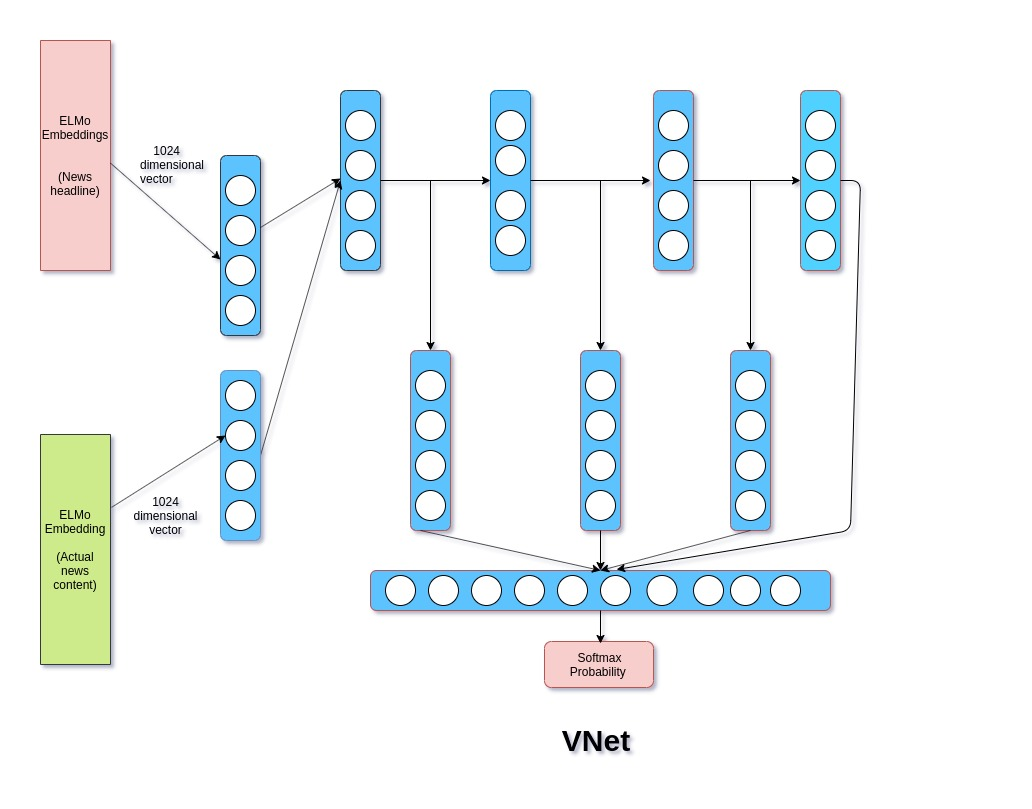

In [0]:
Image("/content/drive/My Drive/Untitled Diagram (2) (1) (1).jpg",width=700, height=500)

In [0]:
from keras import Input 
from keras.models import Model
from keras.layers import Dense,ReLU,concatenate,Dropout,Flatten

## Creating the input layer

In [0]:
input_headline= Input(shape=(1024,))
input_content=Input(shape=(1024,))

In [0]:
top_headline =Dense(512,activation="relu")
top_headline =top_headline(input_headline)
top_headline=Dropout(0.5)(top_headline)

In [0]:
top_content =Dense(512,activation="relu")
top_content =top_content(input_content)
top_content=Dropout(0.5)(top_content)

In [0]:
concatenated_top= concatenate([top_headline,top_content],axis=-1)

## Creating the top layers

In [0]:
layer_top_a =Dense(512,activation="relu")
layer_top_a = layer_top_a(concatenated_top)
layer_top_a = Dropout(0.5)(layer_top_a)

In [0]:
layer_top_b =Dense(512,activation ="relu")
layer_top_b =layer_top_b(layer_top_a)
layer_top_b = Dropout(0.5)(layer_top_b)

In [0]:
layer_top_c =Dense(512,activation ="relu")
layer_top_c =layer_top_c(layer_top_b)
layer_top_c = Dropout(0.5)(layer_top_c)

In [0]:
layer_top_d =Dense(512,activation ="relu")
layer_top_d =layer_top_d(layer_top_c)
layer_top_d = Dropout(0.5)(layer_top_d)

## Creating the middle feature extractors

In [0]:
layer_middle_ab =Dense(256,activation="relu")
layer_middle_ab= layer_middle_ab(layer_top_a)
layer_middle_ab = Dropout(0.5)(layer_middle_ab)

In [0]:
layer_middle_bc =Dense(256,activation="relu")
layer_middle_bc= layer_middle_bc(layer_top_b)
layer_middle_bc = Dropout(0.5)(layer_middle_bc)

In [0]:
layer_middle_cd =Dense(256,activation="relu")
layer_middle_cd= layer_middle_cd(layer_top_c)
layer_middle_cd = Dropout(0.5)(layer_middle_cd)

## Combining all Dense layers 

In [0]:

concatenated_feature_layers=concatenate([layer_middle_ab,layer_middle_bc,layer_middle_cd,layer_top_d],axis=-1)
concatenated_feature_layers=Dropout(0.5)(concatenated_feature_layers)

## prediction layer

In [0]:
dense =  Dense(
    units=2,
    activation='softmax')
prediction_layer =dense(concatenated_feature_layers)

## Defining the model

In [0]:
model = Model(
    inputs=[input_headline, input_content], 
    outputs=prediction_layer)

## Optimizer defining

In [0]:
from keras.optimizers import Adam
lr = 1e-2
opt = Adam(lr=lr, decay=lr/50)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [0]:

from keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('/content/drive/My Drive/paper works/saved models/model.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

## Run the model

In [0]:

history = model.fit(
    x=[elmo_train_top, elmo_train_bm], 
    y=y,
    batch_size=64,
    epochs=5,
        validation_split=0.2,
    shuffle=True
#     callbacks=[cp]

)

Train on 5038 samples, validate on 1260 samples
Epoch 1/5
5038/5038 [==============================] - 1s 205us/step - loss: 0.0371 - acc: 0.9867 - val_loss: 0.5297 - val_acc: 0.8897
Epoch 2/5
5038/5038 [==============================] - 1s 199us/step - loss: 0.0352 - acc: 0.9865 - val_loss: 0.6305 - val_acc: 0.8841
Epoch 3/5
5038/5038 [==============================] - 1s 195us/step - loss: 0.0248 - acc: 0.9907 - val_loss: 0.7268 - val_acc: 0.8857
Epoch 4/5
5038/5038 [==============================] - 1s 191us/step - loss: 0.0326 - acc: 0.9897 - val_loss: 0.5624 - val_acc: 0.8865
Epoch 5/5
5038/5038 [==============================] - 1s 189us/step - loss: 0.0312 - acc: 0.9921 - val_loss: 0.5881 - val_acc: 0.8921


# Results

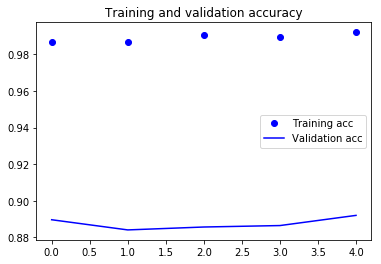

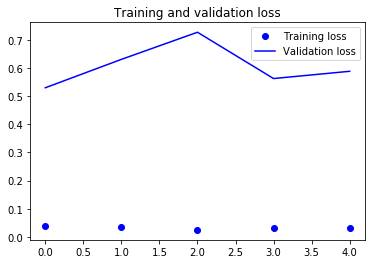

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
import pickle
import pickle
# save elmo_train_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_history.pickle","wb")
pickle.dump(history, pickle_out)
pickle_out.close()

In [0]:
y.shape

(6298, 2)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x1_train, x1_val,x2_train, x2_val,y_train, y_val =train_test_split(elmo_train_top,elmo_train_bm,y,test_size=0.2)
 

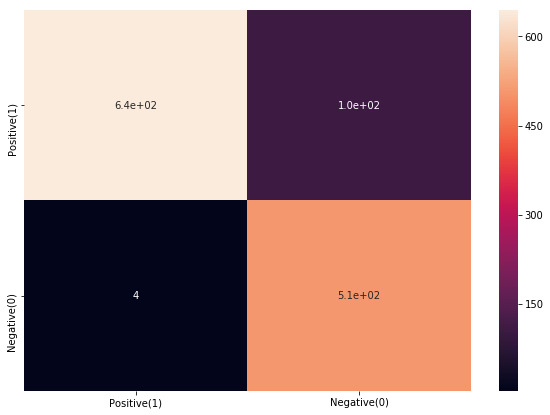

In [0]:
from sklearn import metrics
y_test=model.predict([x1_val,x2_val])
array= metrics.confusion_matrix(y_test.argmax(axis=1), y_val.argmax(axis=1))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, index = [i for i in ["Positive(1)","Negative(0)"]],
                  columns = [i for i in ["Positive(1)","Negative(0)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,)

In [0]:
# from sklearn.metrics import classification_report

In [0]:
# target_names=["fake","real"]

In [0]:
# print(classification_report(y_val, y_test, target_names=target_names))